In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib


# 3.1 - Análise Exploratória de Dados (EDA)
# 3.1.1 - Carregar e examinar o conjunto de dados
base_casas = pd.read_csv("../data/raw/Housing.csv")

# 3.1.2 - Exibir as primeiras linhas do dataset
print("\n Primeiras 5 linhas do dataset:")
print(base_casas.head())

print("\n Resumo estatístico dos dados iniciais:")
print(base_casas.describe())


 Primeiras 5 linhas do dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

 Resumo estatístico dos dados iniciais:
              price      

In [36]:
# 3.1.3 - Verificar informações gerais do dataset
print("\n Informações gerais do dataset:")
print(base_casas.info())


 Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [37]:
# 3.1.4 - Verificar valores ausentes
print("\n Valores ausentes por coluna:")
print(base_casas.isnull().sum())


 Valores ausentes por coluna:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [38]:
# 3.1.5 - Converter variáveis categóricas binárias (Yes/No → 0/1)
# Lista de colunas booleanas
bool_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Limpa os dados e transforma 'yes'/'no' em 1/0
for col in bool_columns:
    base_casas[col] = base_casas[col].astype(str).str.strip().str.lower()
    base_casas[col] = base_casas[col].replace({'yes': 1, 'no': 0})
print("\n Primeiras 5 linhas do dataset:")
print(base_casas[bool_columns].head())



 Primeiras 5 linhas do dataset:
   mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea
0         1          0         0                0                1         1
1         1          0         0                0                1         0
2         1          0         1                0                0         1
3         1          0         1                0                1         1
4         1          1         1                0                1         0


In [39]:
# 3.1.6 - Converter variáveis categóricas múltiplas (Furnishing Status)
base_casas = pd.get_dummies(base_casas, columns=['furnishingstatus'], drop_first=True)
print(base_casas.head())

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0                            False                         False  
1                       

In [40]:
# 3.1.7 - Preencher valores ausentes com a mediana (agora todas as colunas são numéricas)
base_casas.fillna(base_casas.median(), inplace=True)

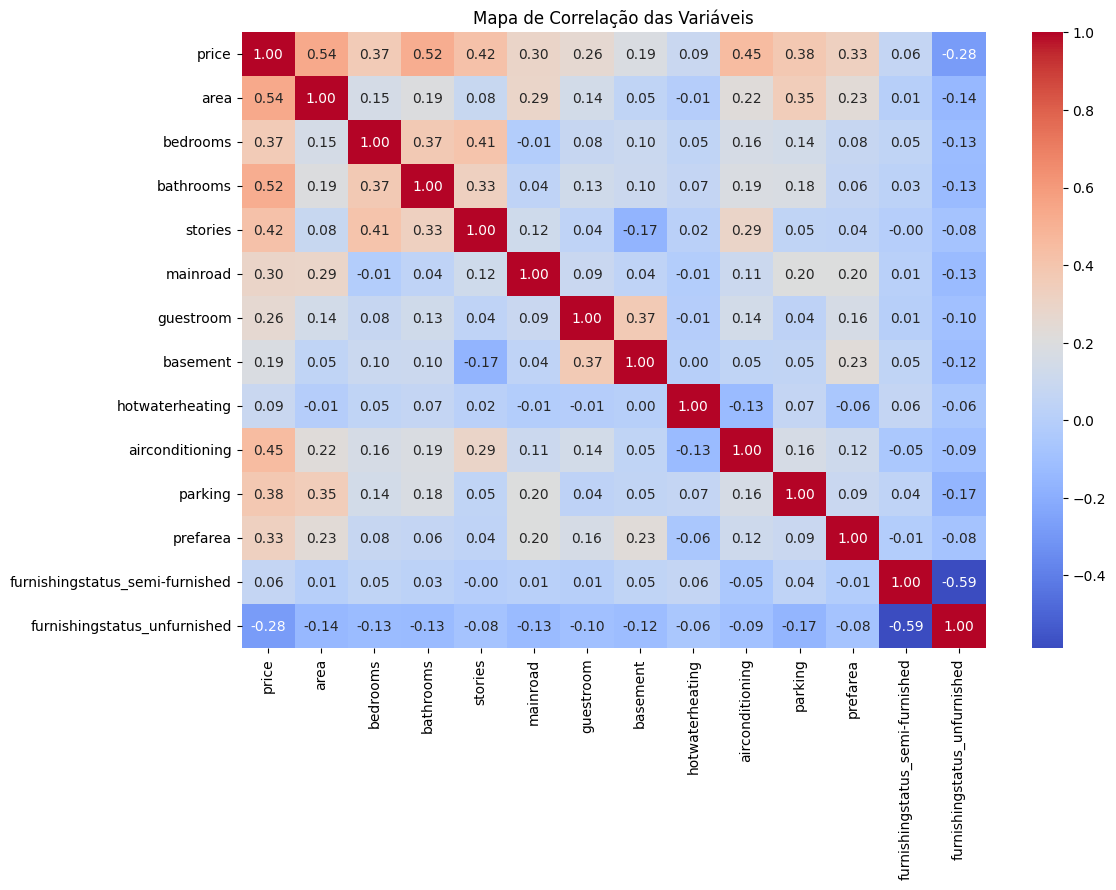

In [41]:
plt.figure(figsize=(12,8))
sns.heatmap(base_casas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação das Variáveis")
plt.show()

#area: 0.54 Quanto maior a área da casa, maior tende a ser o preço.

#bathrooms: 0.52 Casas com mais banheiros tendem a ter preços mais altos.

#furnishingstatus_unfurnished: -0.28 Casas não mobiliadas tendem a ter preços mais baixos.

In [42]:
# 3.1.9 - Identificar e lidar com outliers usando IQR em colunas específicas
#limpar somente price e area, evitando perder variáveis importantes como prefarea, hotwaterheating
outlier_cols = ['price', 'area']

Q1 = base_casas[outlier_cols].quantile(0.25)
Q3 = base_casas[outlier_cols].quantile(0.75)
IQR = Q3 - Q1

print("\n  1º Quartil (Q1) – 25% dos dados abaixo:")
print(Q1)

print("\n  3º Quartil (Q3) – 75% dos dados abaixo:")
print(Q3)

print("\n  Intervalo Interquartil (IQR = Q3 - Q1):")
print(IQR)

print(f"\n  Tamanho do DataFrame antes de remover outliers: {base_casas.shape}")

fator = 3 
filtro = ~((base_casas[outlier_cols] < (Q1 - fator * IQR)) | 
           (base_casas[outlier_cols] > (Q3 + fator * IQR))).any(axis=1)

base_casas = base_casas[filtro]

print(f" Tamanho do DataFrame depois de remover outliers: {base_casas.shape}")



  1º Quartil (Q1) – 25% dos dados abaixo:
price    3430000.0
area        3600.0
Name: 0.25, dtype: float64

  3º Quartil (Q3) – 75% dos dados abaixo:
price    5740000.0
area        6360.0
Name: 0.75, dtype: float64

  Intervalo Interquartil (IQR = Q3 - Q1):
price    2310000.0
area        2760.0
dtype: float64

  Tamanho do DataFrame antes de remover outliers: (545, 14)
 Tamanho do DataFrame depois de remover outliers: (542, 14)


In [43]:
# 3.1.10 - Exibir estatísticas básicas após a limpeza dos dados
print("\n  Resumo estatístico dos dados limpos:")
print(base_casas.describe())


  Resumo estatístico dos dados limpos:
              price          area    bedrooms   bathrooms     stories  \
count  5.420000e+02    542.000000  542.000000  542.000000  542.000000   
mean   4.738883e+06   5106.688192    2.959410    1.282288    1.804428   
std    1.823855e+06   2072.841761    0.733547    0.497331    0.867645   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3588.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4540.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.225000e+07  13200.000000    6.000000    4.000000    4.000000   

         mainroad   guestroom    basement  hotwaterheating  airconditioning  \
count  542.000000  542.000000  542.000000       542.000000       542.000000   
mean     0.857934    0.178967    0.352399         0.046125         0.313653   
std      0.349441    0.383679    0.478159         0.209951       

In [44]:
# 3.2 - Engenharia e Seleção de Features
# 3.2.1 - Criar variáveis relevantes que possam melhorar o desempenho do modelo

# Casas grandes com poucos banheiros podem ter valor menor, ou não.
base_casas['area_per_bathroom'] = base_casas['area'] / base_casas['bathrooms']

# Talvez a Casa A tenha quartos maiores (ou mais confortáveis), o que pode influenciar o preço, ou não.
base_casas['area_per_bedroom'] = base_casas['area'] / base_casas['bedrooms']

# 3.2.2 - Aplicar transformações apropriadas às variáveis (normalização)
scaler = MinMaxScaler()
base_casas[['area_per_bedroom', 'area_per_bathroom']] = scaler.fit_transform(
    base_casas[['area_per_bedroom', 'area_per_bathroom']]
)

# Print das novas variáveis após normalização
print("\n  Novas variáveis normalizadas:")
print(base_casas[['area_per_bedroom', 'area_per_bathroom']].head())



  Novas variáveis normalizadas:
   area_per_bedroom  area_per_bathroom
1          0.298923           0.111111
2          0.472584           0.333333
3          0.240232           0.233577
4          0.237016           0.531225
5          0.340730           0.132198


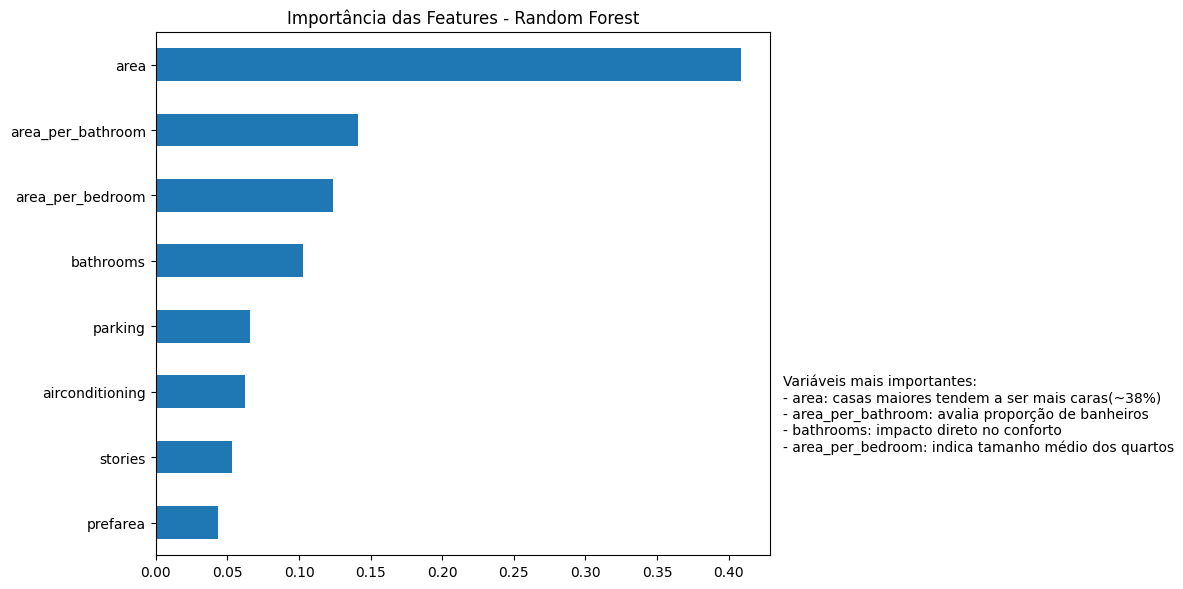

In [45]:
# 3.2.3 - Selecionar as variáveis mais importantes para o modelo utilizando Random Forest
features_importantes = [
    'area', 
    'area_per_bathroom', 
    'bathrooms', 
    'area_per_bedroom', 
    'airconditioning',
    'parking',
    'stories',
    'prefarea'
]
X = base_casas[features_importantes]
y = base_casas['price']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(12, 6), title="Importância das Features - Random Forest")

explicacao = (
    "Variáveis mais importantes:\n"
    "- area: casas maiores tendem a ser mais caras(~38%)\n"
    "- area_per_bathroom: avalia proporção de banheiros\n"
    "- bathrooms: impacto direto no conforto\n"
    "- area_per_bedroom: indica tamanho médio dos quartos"
)
plt.text(1.02, 0.2, explicacao, fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²(coeficiente de determinação):", r2)
print(" MAE (Erro Absoluto Médio):", mae)
print(" RMSE (Raiz do Erro Quadrático Médio):", rmse)



R²(coeficiente de determinação): 0.5281311148434176
 MAE (Erro Absoluto Médio): 1080633.6896024465
 RMSE (Raiz do Erro Quadrático Médio): 1473680.63291275


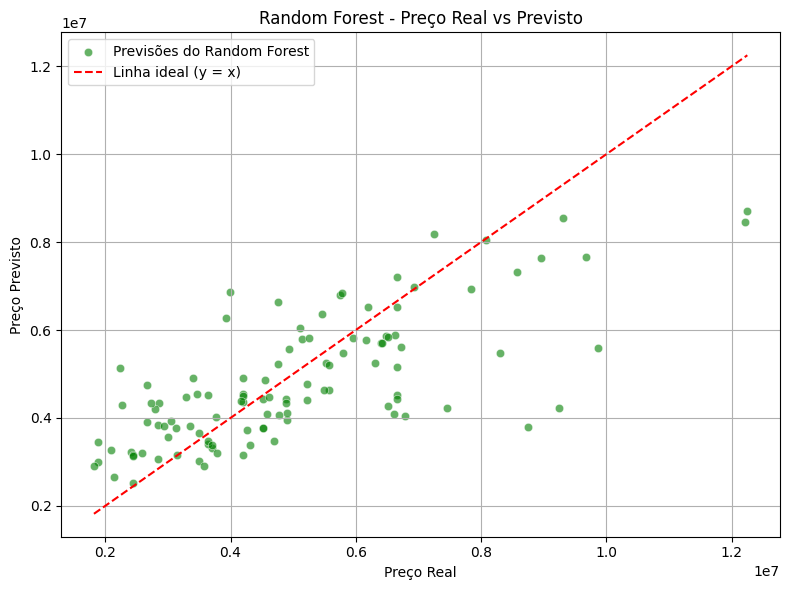

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='green', alpha=0.6, label='Previsões do Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Linha ideal (y = x)')
plt.xlabel("Preço Real")
plt.ylabel("Preço Previsto")
plt.title("Random Forest - Preço Real vs Previsto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
#3.3.2 - Ajustar hiperparâmetros usando métodos apropriados.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

# GridSearchCV para buscar a melhor combinação
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Treina nos dados
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
melhor_rf = grid_search.best_estimator_

print("\ncombinação de hiperparâmetros encontrada:")
print(grid_search.best_params_)

# Avaliar no conjunto de teste
y_pred_rf = melhor_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n Desempenho do Random Forest com hiperparâmetros otimizados:")
print("R²(coeficiente de determinação):", r2)
print(" MAE (Erro Absoluto Médio):", mae)
print(" RMSE (Raiz do Erro Quadrático Médio):", rmse)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

combinação de hiperparâmetros encontrada:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

 Desempenho do Random Forest com hiperparâmetros otimizados:
R²(coeficiente de determinação): 0.5551342012697686
 MAE (Erro Absoluto Médio): 1049534.4214125304
 RMSE (Raiz do Erro Quadrático Médio): 1430893.183425447


In [49]:


fig = make_subplots(rows=1, cols=2, subplot_titles=[
    "Random Forest - Antes da Otimização",
    "Random Forest - Após Otimização"
])

fig.add_trace(
    go.Scatter(
        x=y_test, y=y_pred,
        mode='markers',
        name='Previsões RF',
        marker=dict(color='green', opacity=0.6),
        hovertemplate='Preço Real: %{x}<br>Previsto: %{y}'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        name='Linha Ideal',
        line=dict(color='red', dash='dash')
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=y_test, y=y_pred_rf,
        mode='markers',
        name='Previsões RF Otimizado',
        marker=dict(color='blue', opacity=0.6),
        hovertemplate='Preço Real: %{x}<br>Previsto: %{y}'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        name='Linha Ideal',
        line=dict(color='red', dash='dash')
    ),
    row=1, col=2
)

fig.update_layout(
    title="Previsão de Preços - Random Forest",
    height=600,
    width=1400,
    showlegend=True
)

fig.show()


In [50]:
print("Tipo:", type(melhor_rf))
print("Features:", melhor_rf.feature_names_in_)

joblib.dump({
    'modelo': melhor_rf,
    'scaler': scaler
}, '../models/modelo_rf.pkl')

Tipo: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Features: ['area' 'area_per_bathroom' 'bathrooms' 'area_per_bedroom'
 'airconditioning' 'parking' 'stories' 'prefarea']


['../models/modelo_rf.pkl']

In [51]:
# 3.2.3.1 - Complementar análise de features com Regrerssão linear multipla
features_importantes = [
    'area', 
    'area_per_bathroom', 
    'bathrooms', 
    'area_per_bedroom', 
    'airconditioning',
    'parking',
    'stories',
    'prefarea'
]
X = base_casas[features_importantes]
y = base_casas['price']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo_lr.predict(X_test)

# Avaliar o modelo
print(" R² (coeficiente de determinação):", r2_score(y_test, y_pred))
print(" MAE (Erro Absoluto Médio):", mean_absolute_error(y_test, y_pred))
print(" RMSE (Raiz do Erro Quadrático Médio):", np.sqrt(mean_squared_error(y_test, y_pred)))

# Coeficientes das variáveis
coeficientes = pd.Series(modelo_lr.coef_, index=X.columns)
print("\n  Coeficientes das variáveis (impacto no preço):")
print(coeficientes.sort_values(ascending=False))

#Variável              | Interpretação
#----------------------|---------------------------------------------------------------
#airconditioning       | Casas com ar-condicionado valem mais
#prefarea              | Localização preferencial tem grande peso
#bathrooms             | Mais banheiros = mais conforto
#stories               | Casas de mais andares valem mais
#parking               | Vaga de garagem influencia no preço
#area                  | A cada m², o preço aumenta em média R$ 487
#area_per_bathroom     | Pode indicar casas com poucos banheiros para o tamanho
#area_per_bedroom      | Pode indicar quartos pequenos ou mal distribuídos


 R² (coeficiente de determinação): 0.630541599653417
 MAE (Erro Absoluto Médio): 942516.7262436023
 RMSE (Raiz do Erro Quadrático Médio): 1303993.6552559067

  Coeficientes das variáveis (impacto no preço):
airconditioning      9.593998e+05
prefarea             6.674899e+05
bathrooms            6.006794e+05
stories              3.926725e+05
parking              2.451036e+05
area                 4.870991e+02
area_per_bedroom    -1.472204e+06
area_per_bathroom   -1.720821e+06
dtype: float64


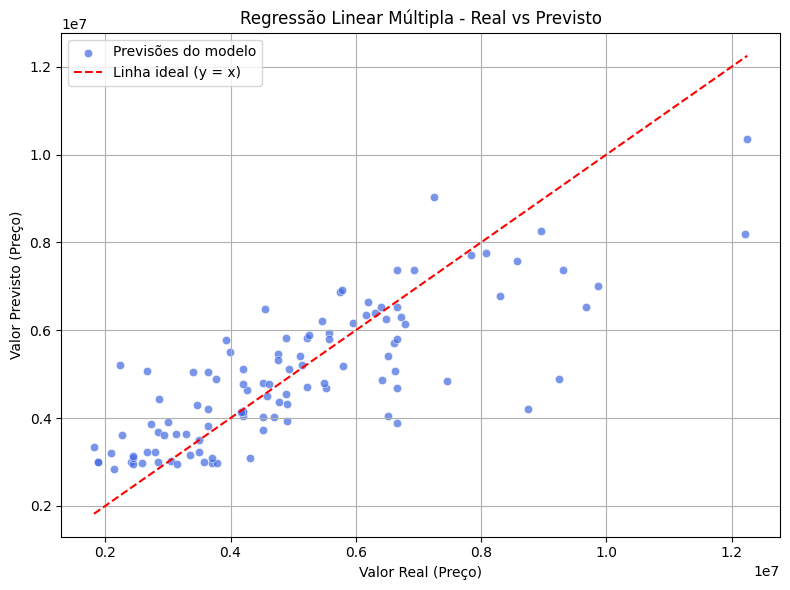

In [52]:
plt.figure(figsize=(8, 6))

#previsões
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.7, label='Previsões do modelo')

#linha ideal
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Linha ideal (y = x)')

plt.xlabel("Valor Real (Preço)")
plt.ylabel("Valor Previsto (Preço)")
plt.title("Regressão Linear Múltipla - Real vs Previsto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



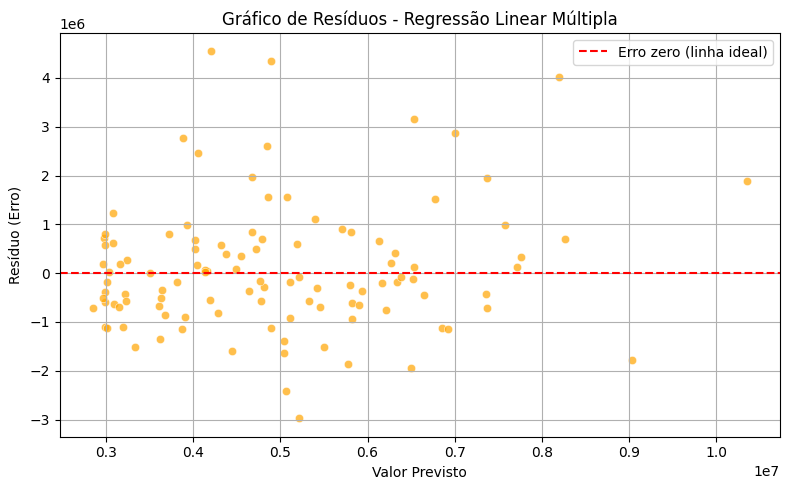

In [53]:
# Calcular resíduos
residuos = y_test - y_pred

# Gráfico de resíduos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.7, color='orange')
plt.axhline(0, color='red', linestyle='--', label='Erro zero (linha ideal)')
plt.xlabel("Valor Previsto")
plt.ylabel("Resíduo (Erro)")
plt.title("Gráfico de Resíduos - Regressão Linear Múltipla")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
#3.3.2 - Ajustar hiperparâmetros usando métodos apropriados (Ridge)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
modelo_ridge = Ridge()

grid_ridge = GridSearchCV(modelo_ridge, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

melhor_ridge = grid_ridge.best_estimator_
print("Melhor alpha encontrado:", grid_ridge.best_params_)

y_pred_ridge = melhor_ridge.predict(X_test)
print("\n Avaliação Ridge após ajuste de hiperparâmetros:")
print("R²(coeficiente de determinação):", r2_score(y_test, y_pred_ridge))
print(" MAE (Erro Absoluto Médio):", mean_absolute_error(y_test, y_pred_ridge))
print(" RMSE (Raiz do Erro Quadrático Médio):", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))



Melhor alpha encontrado: {'alpha': 1}

 Avaliação Ridge após ajuste de hiperparâmetros:
R²(coeficiente de determinação): 0.6299514930484333
 MAE (Erro Absoluto Médio): 941226.4947366359
 RMSE (Raiz do Erro Quadrático Médio): 1305034.6225878147


In [55]:
# Gráfico comparativo (antes e depois do ajuste Ridge)
fig = make_subplots(rows=1, cols=2, subplot_titles=[
    "Regressão Linear (Sem Ajuste)",
    "Regressão Ridge (Com Ajuste)"
])

fig.add_trace(
    go.Scatter(
        x=y_test, y=y_pred,
        mode='markers',
        name='Linear Regression',
        marker=dict(color='royalblue', opacity=0.7),
        hovertemplate='Preço Real: %{x}<br>Preço Previsto: %{y}'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        name='Linha ideal',
        line=dict(color='red', dash='dash')
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=y_test, y=y_pred_ridge,
        mode='markers',
        name='Ridge Regression',
        marker=dict(color='darkorange', opacity=0.7),
        hovertemplate='Preço Real: %{x}<br>Preço Previsto: %{y}'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        name='Linha ideal',
        line=dict(color='red', dash='dash')
    ),
    row=1, col=2
)

fig.update_layout(
    title="Comparação: Regressão Linear vs Ridge (com ajuste de hiperparâmetros)",
    height=600,
    width=1400,
    showlegend=True
)

fig.show()

#| Métrica   | Regressão Linear Múltipla (sem ajuste) | Ridge (após ajuste) |
#|-----------|----------------------------------------|---------------------|
#| **R²**    | **0.6305**                             | 0.6299              |
#  **MAE**   | R$ 942.516                             | **R$ 941.226**      |
#| **RMSE**  | **R$ 1.303.993**                       | R$ 1.305.034        |
# conclusão que refinou muito pouco o modelo.


In [56]:
joblib.dump({
    'modelo': melhor_ridge,
    'scaler': scaler
}, '../models/modelo_ridge.pkl')
base_casas.to_csv("../data/processed/Housing_cleaned.csv", index=False)
'''
### Comparação Geral:
- O **Ridge** supera o **Random Forest** em todas as métricas:
  - Explica mais da variância dos dados (R² mais alto).
  - Tem menor erro absoluto médio (MAE mais baixo).
  - Tem menor erro quadrático médio (RMSE mais baixo).
'''

'\n### Comparação Geral:\n- O **Ridge** supera o **Random Forest** em todas as métricas:\n  - Explica mais da variância dos dados (R² mais alto).\n  - Tem menor erro absoluto médio (MAE mais baixo).\n  - Tem menor erro quadrático médio (RMSE mais baixo).\n'